In [138]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
from datasets import load_dataset

dataset_name = "cellxgene_pseudo_bulk_3_5k_multiplets_cell_type"
dataset = load_dataset(f"jo-mengr/{dataset_name}")
test_dataset = dataset["train"]
# test_dataset = load_dataset("jo-mengr/human_pancreas_norm_complexBatch_single")["train"]

In [ ]:
from sentence_transformers import SentenceTransformer

model_name = "mmcontext-3.5k-cell_type-geneformer-2048"
model = SentenceTransformer(f"jo-mengr/{model_name}")

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, torch.memory_format memory_format = None, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [11]:
og_text_encoder = model[0].text_encoder_name
text_encoder = SentenceTransformer(og_text_encoder)

In [7]:
from mmcontext.utils import load_test_adata_from_hf_dataset

adata = load_test_adata_from_hf_dataset(test_dataset)

In [8]:
from datasets import Dataset

if "pairs" in dataset_name:
    test_dataset = test_dataset.filter(lambda x: x["label"] == 1.0)

In [12]:
omics_embeddings = model.encode(test_dataset["anndata_ref"])
text_embeddings = model.encode(adata.obs["natural_language_annotation"].values.tolist())
adata.obsm["mmcontext_emb"] = omics_embeddings
adata.obsm["mmcontext_text_emb"] = text_embeddings
adata.obsm["og_text_emb"] = text_encoder.encode(adata.obs["natural_language_annotation"].values.tolist())

In [74]:
adata.obs["natural_language_annotation"].values[4]

'Activated CD16-positive, CD56-dim natural killer cell from a 26-year-old male, taken from blood.'

In [13]:
batch_key = "assay"
adata.obs[batch_key] = adata.obs[batch_key].astype("category")

In [60]:
# make Nans to "other" in batch
# adata.obs[batch_key] = adata.obs[batch_key].cat.add_categories("other")
adata.obs[batch_key].fillna("other", inplace=True)
adata.obs["batch"].value_counts()

/var/folders/x3/bj_4mgb56c19542qzptvc36c0000gn/T/ipykernel_31173/628439829.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs[batch_key].fillna("other", inplace=True)


batch
5                  30
2                  27
4                  16
0                  15
1                  13
                   ..
CV001_KM8854508     1
CV001_KM8854459     1
CV001_KM8854458     1
CV001_KM8853695     1
CV001_KM8854610     1
Name: count, Length: 151, dtype: int64

In [40]:
adata.obs["cell_type"].value_counts()
# subset all neurons
adata_neuron = adata[adata.obs["cell_type"] == "neuron"]
# then filter for cerebral coretex tissue
adata_neuron_cortex = adata_neuron[adata_neuron.obs["tissue"] == "cerebral cortex"]

In [68]:
del adata.uns["batch_colors"]

<Figure size 800x800 with 0 Axes>

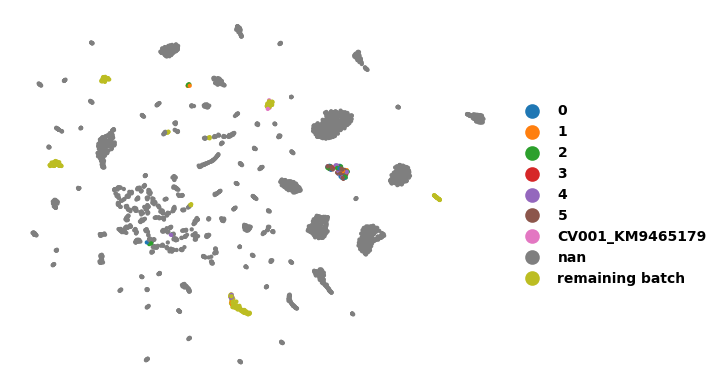

In [69]:
# Visualise the embeddings
from mmcontext.pl import plot_umap
from mmcontext.pp.utils import consolidate_low_frequency_categories

adata_cut = consolidate_low_frequency_categories(adata, ["batch"], threshold=5)
label_key = "batch"
emb_key = "mmcontext_emb"
plot_umap(
    adata_cut,
    color_key=label_key,
    embedding_key=emb_key,
    save_format="svg",
    nametag=f"neurons_{label_key}",
    save_dir=f"figs/{model_name}/{dataset_name}",
    save_plot=False,
    title="",
)

<Figure size 800x800 with 0 Axes>

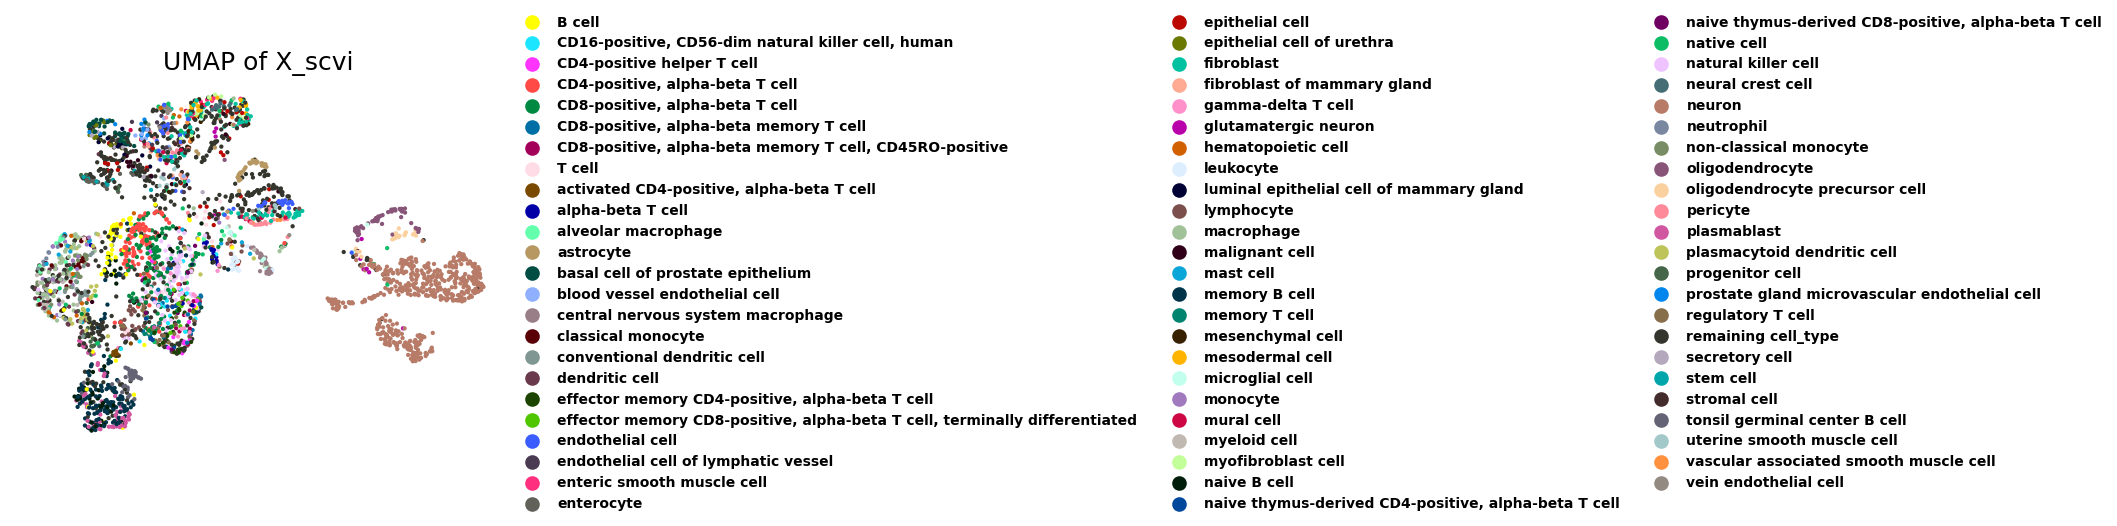

In [61]:
plot_umap(adata_cut, color_key=label_key, embedding_key="X_scvi")

In [128]:
from mmcontext.eval.utils import create_emb_pair_dataframe

emb_pair_df = create_emb_pair_dataframe(
    adata,
    emb1_key="mmcontext_emb",
    emb2_key="mmcontext_text_emb",
    subset_size=20,
    label_keys=["_scvi_batch", "cell_type"],
)

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/utils.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  base_row[label_key] = adata.obs[label_key][sampled_indices[idx]]


/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


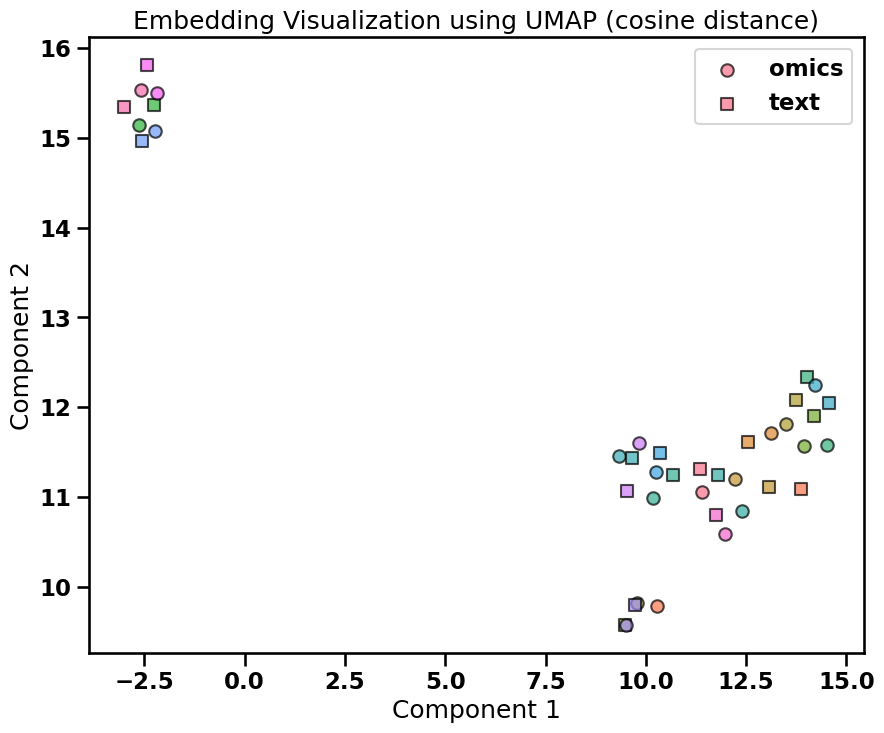

In [125]:
from mmcontext.pl import visualize_embedding_clusters

visualize_embedding_clusters(emb_pair_df, method="umap", metric="cosine", n_neighbors=15, min_dist=0.1, random_state=42)

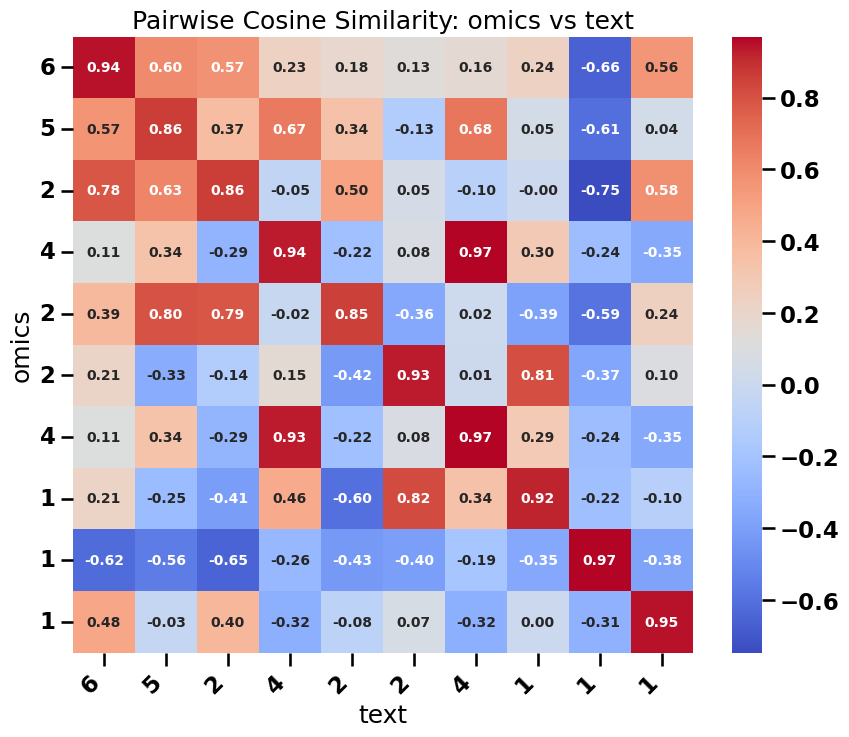

In [147]:
from mmcontext.pl.plotting import plot_embedding_similarity

plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", subset=10, label_key="_scvi_batch")

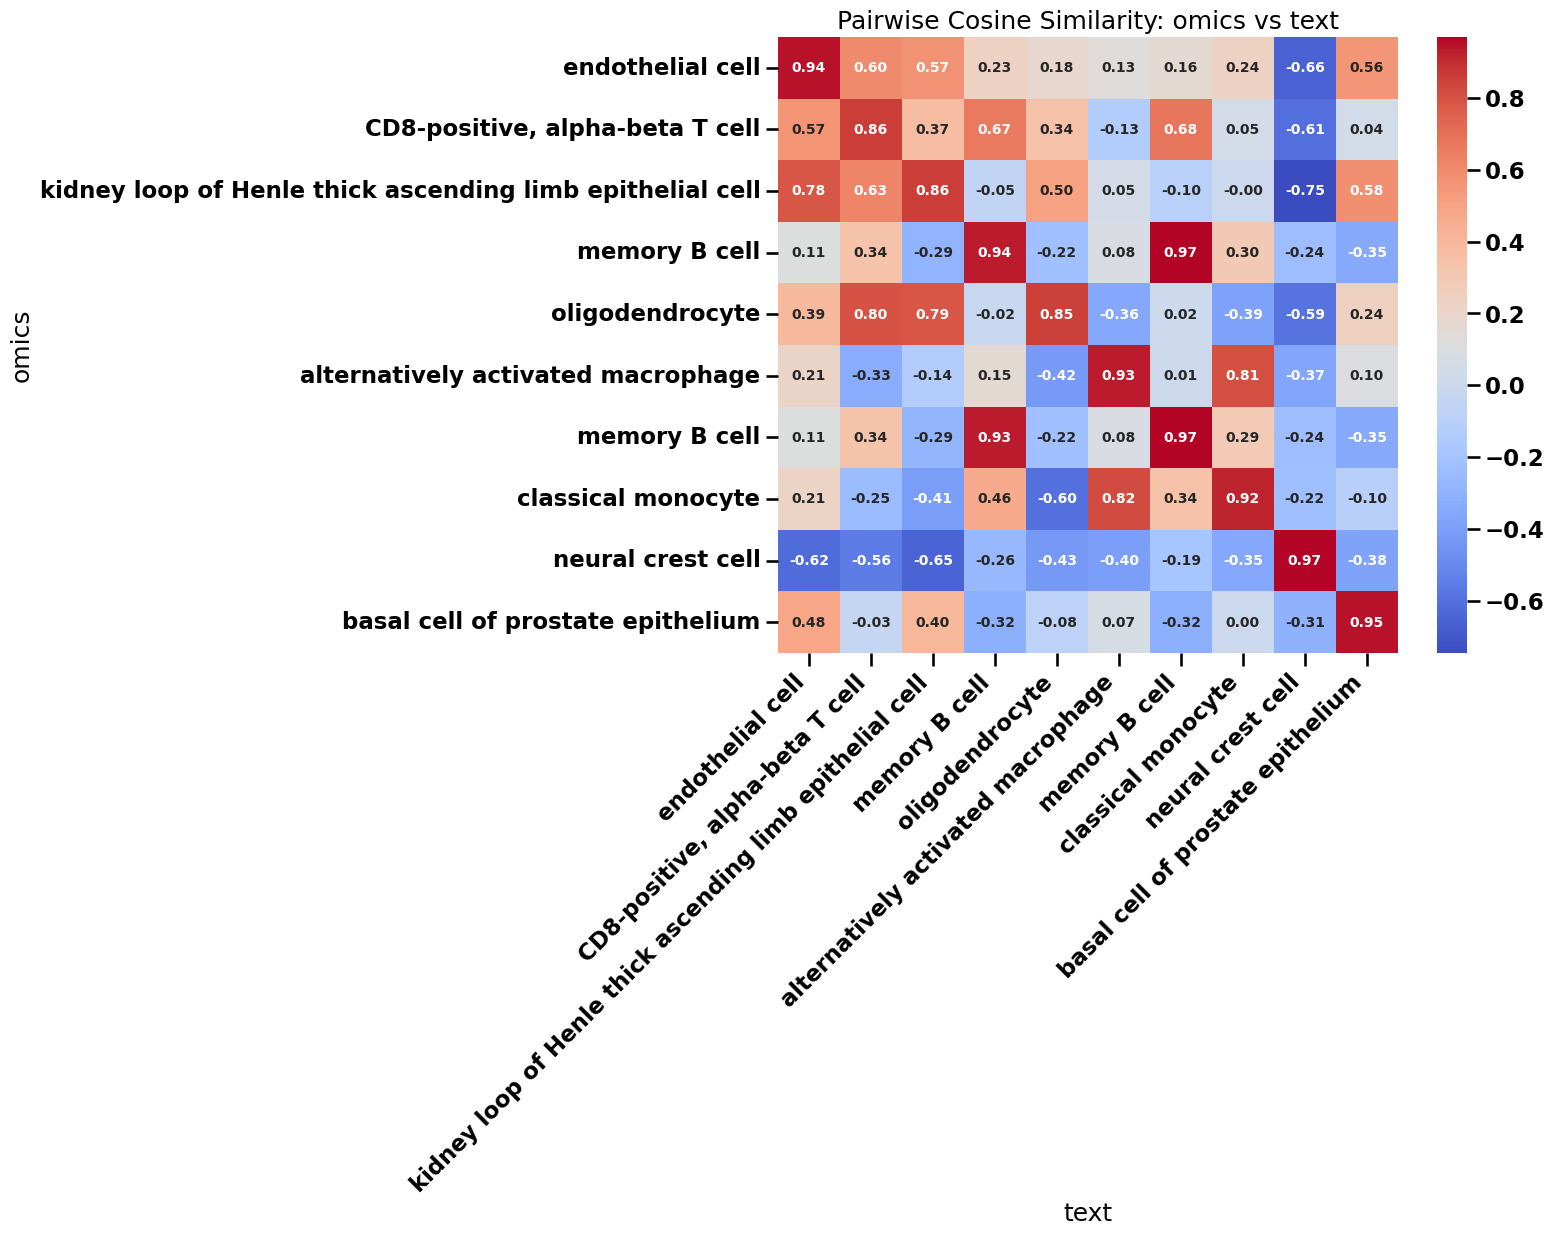

In [148]:
from mmcontext.pl.plotting import plot_embedding_similarity

plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", subset=10, label_key="cell_type")

In [96]:
from mmcontext.eval.utils import create_emb_pair_dataframe

# only show similarities within one batch
emb_pair_df = create_emb_pair_dataframe(
    adata,
    emb1_key="mmcontext_emb",
    emb2_key="mmcontext_text_emb",
    subset_size=100,
    obs_filter_key="_scvi_batch",
    obs_filter_value=2,
)

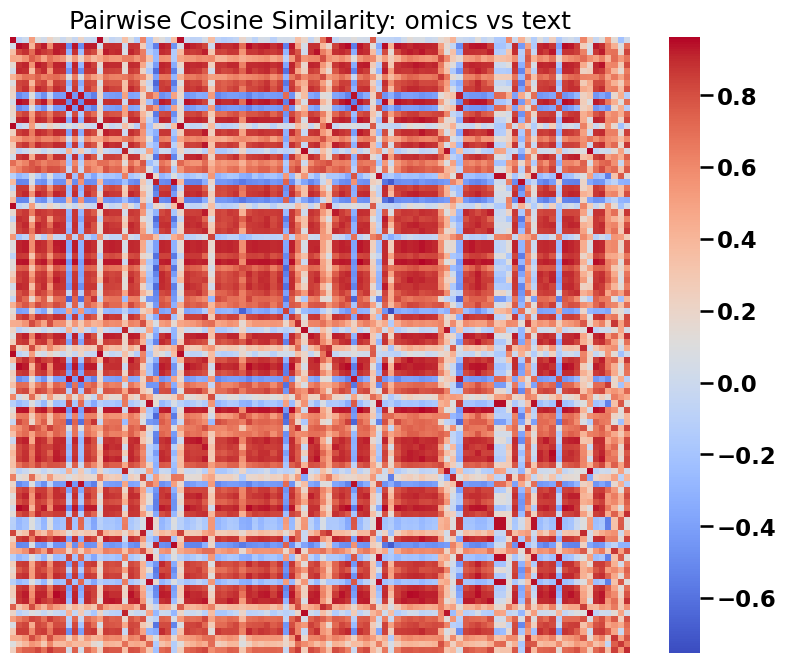

In [98]:
from mmcontext.pl.plotting import plot_embedding_similarity

plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", subset=100)

In [49]:
from mmcontext.pp import remove_zero_variance_cells, remove_zero_variance_genes

adata = remove_zero_variance_cells(adata)
adata = remove_zero_variance_genes(adata)

ImportError: cannot import name 'remove_zero_variance_cells' from 'mmcontext.pp' (/Users/mengerj/repos/mmcontext/src/mmcontext/pp/__init__.py)

In [42]:
from mmcontext.eval import scibEvaluator

evalutator = scibEvaluator(
    adata=adata,
    batch_key="batch",
    label_key="cluster_lavel",
    embedding_key=["mmcontext_emb", "mmcontext_text_emb", "X_geneformer", "X_hvg", "X_pca", "X_scvi"],
    n_top_genes=5000,
    max_cells=5000,
)
res = evalutator.evaluate()

HVG


Error in data reduction: Bin edges must be unique: Index([               -inf,  -2.892823703725029, -0.6085385346302277,
       0.09924078048896734, 0.09924078048896734, 0.09924079373444396,
       0.14027225325936107, 0.18885910880786402, 0.23705809401106778,
          0.30732003013017,  0.4241397468442167,   0.611900446591554,
        0.9100024470921467,  1.3157359159517066,  1.9957290970961805,
         2.822801220996513,   3.787105232711744,    5.15218205363662,
         7.423641985710012,  100.20904103227615,                 inf],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg
Using full data for metrics computation.


HVG
Cluster for cluster_0.2 with leiden


KeyError: 'No "neighbors" in .uns'